In [2]:
"""

2022/10/03 
ABCD method for probQ vs Ias
for singleMu tracker-only analysis

"""

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd
import math
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
from scipy.stats import norm


import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# load mass distributions

In [24]:
fpath =OrderedDict()
mass = OrderedDict()



path = "/storage/af/group/phys_exotica/HSCPAnalyzer/V1p0/MC_UL18/v2/normalized/"

signal = [
    'gluino_M-1800',
]


bkg = [

    'WJetsToLNu',
    'WJetsToLNu_012J',
    'QCD_Pt-50_MuEnrichedPt5',
    'TTTo2L2Nu',
    'TTToSemiLeptonic',

]

data =[
    "SingleMuon_Run2018C",
]
for s in signal:
    fpath[s] = path + 'HSCP' + s+ '_TuneCP5_13TeV-pythia8_1pb_weighted.root'
for b in bkg:
    if 'QCD' in b: fpath[b] = path + b+ '_TuneCP5_13TeV-pythia8_1pb_weighted.root'
    elif 'TT' in b: fpath[b] = path + b+ '_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
    else:fpath[b] = path + b+ '_TuneCP5_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'

        
path = '/storage/af/group/phys_exotica/HSCPAnalyzer/V1p0/Data_UL/SingleMuon/v1/normalized/'

for d in data:
    fpath[d] = path + 'HSCPNtupler_' + d + '_CodeV1p0_v1_goodLumi.root'


lumi =10 * 1000
tree = {}
NEvents = {}
for k,v in fpath.items():

    root_dir = uproot.open(v)
    NEvents[k] = root_dir['NEvents'].values[0]
    tree[k] = root_dir['tree']
    

    if k in data: print(k, '\t', np.sum(tree[k].array('weight')))
    else: print(k, '\t', lumi*np.sum(tree[k].array('weight')))

gluino_M-1800 	 3.3372367033734918
WJetsToLNu 	 27277177.734375
WJetsToLNu_012J 	 24987014.16015625
QCD_Pt-50_MuEnrichedPt5 	 28140893.5546875
TTTo2L2Nu 	 264710.7124328613
TTToSemiLeptonic 	 731275.8636474609
SingleMuon_Run2018C 	 4618827.0


In [12]:
#### implement pre-selection
ias = {}
probq = {}
weight = {}
HSCP_pt = {}
HSCP_eta = {}
met = {}
metPhi = {}
for k, T in tree.items():
    sel_hscp = T.array('HSCP_pt') > 55
    sel_hscp = np.logical_and(sel_hscp, np.abs(T.array('HSCP_eta'))<1)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_nPixelHit') >= 2)

    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_nHits') > 9)

    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_isHighPurity'))
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_fracValidHits') > 0.8)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_dZ') < 0.1)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_dXY') < 0.02)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_EOverP') < 0.3)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_chi2')/T.array('HSCP_nDof') < 5)

    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_track_genTrackMiniIsoSumPt') < 15)

    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_pfMiniIso_relative')< 0.02)

    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_probQ') < 0.7)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_probQ') > 0.0)
    sel_hscp = np.logical_and(sel_hscp, T.array('HSCP_ptErr')/T.array('HSCP_pt')**2 < 0.0008)

    sel_ev = np.logical_and(sel_hscp.sum()>0, T.array('HLT_Mu50'))

    probq[k] = T.array('HSCP_probQ')[sel_hscp][sel_ev]
    ias[k] = T.array('HSCP_ias_StripOnly')[sel_hscp][sel_ev]
    if k in data:
        weight[k] = T.array('weight')[sel_ev]*1.0


    else:
    #     weight[k] = T.array('weight')[sel_ev]*T.array('pileupWeight')[sel_ev]*lumi + T.array('HSCP_probQ')[sel_hscp][sel_ev]*0.0
        weight[k] = T.array('weight')[sel_ev]*T.array('pileupWeight')[sel_ev]*lumi
    HSCP_pt[k] = T.array('HSCP_pt')[sel_hscp][sel_ev]
    HSCP_eta[k] = T.array('HSCP_eta')[sel_hscp][sel_ev]


    metPhi[k] = T.array('metPhi')[sel_ev]

    print(k, NEvents[k], np.sum(weight[k]), np.sum(weight[k])/len(weight[k]))


gluino_M-1800 96454.0 0.2976859 5.196123082385177e-05
WJetsToLNu 670052840000.0 681171.4 18.45992886178862


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


WJetsToLNu_012J 8290677000000.0 591415.4 0.19777880016199115
QCD_Pt-50_MuEnrichedPt5 214305380.0 7201.351 0.9715800154099771
TTTo2L2Nu 6704168400.0 12519.945 0.001615109403177058
TTToSemiLeptonic 46621890000.0 31654.65 0.004009630615983219
SingleMuon_Run2018C 4747798.0 296493.0 1.0
0.5013279


# stack plots

TTTo2L2Nu 12519.947035776684
TTToSemiLeptonic 31654.650887046708
QCD_Pt-50_MuEnrichedPt5 7201.351150452276
WJetsToLNu_012J 591415.0452840924
SingleMuon_Run2018C 296493.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: TTTo2L2Nu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: TTToSemiLeptonic (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_Pt-50_MuEnrichedPt5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: WJetsToLNu_012J (Potential memory leak).


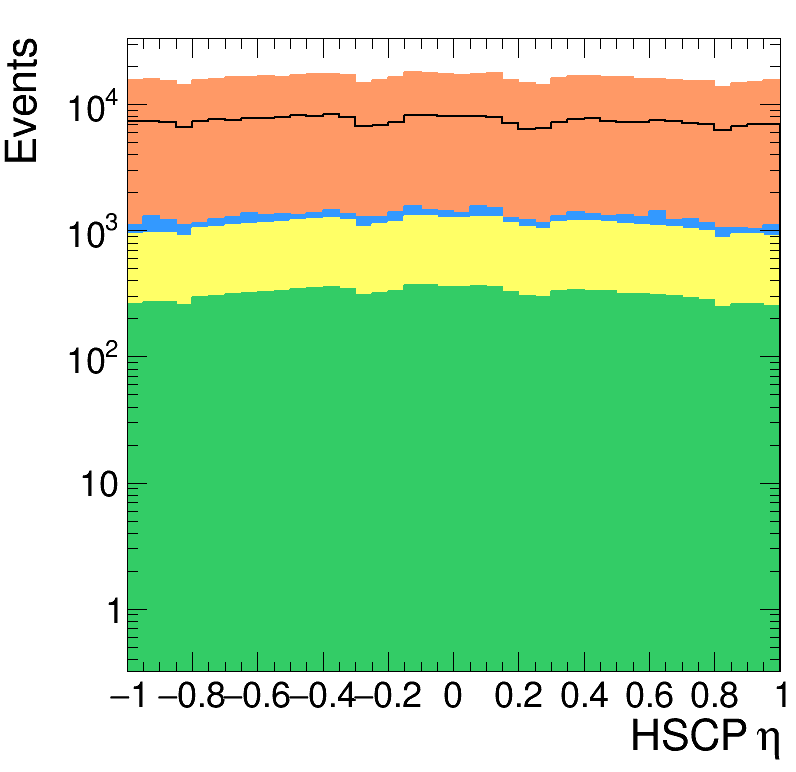

In [17]:
# Plotting THStack
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.97,0.93)

leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
stack = rt.THStack( "hs" , "Hgg Stack " )
color_list = [845,393,861,806,876,597,625,  2,3,4,5]
var = [HSCP_pt, HSCP_eta]
xaxis = ['HSCP pT [GeV]', 'HSCP #eta']
save = ['nocut_jet1Pt', 'nocut_jet2Pt', 'nocut_jetTime', 'nocut_jetEta', 'nocut_jetPhi', 'nocut_lepPt', 'nocut_lepEta', 'nocut_lepPhi', 'nocut_metPhi', 'nocut_met', 'nocut_weight']

bins = [[40,0,1000],[40,-1,1]]
setlog = [1,1,0,0,0,1,0,0,0,1,0]
bkg_keys = ['QCD_Pt-50_MuEnrichedPt5','WJetsToLNu_012J']

bkg_keys = [
    'QCD_Pt-1000_MuEnrichedPt5',
'QCD_Pt-120To170_MuEnrichedPt5',
'QCD_Pt-170To300_MuEnrichedPt5',
'QCD_Pt-300To470_MuEnrichedPt5',
'QCD_Pt-470To600_MuEnrichedPt5',
'QCD_Pt-50To80_MuEnrichedPt5',
'QCD_Pt-50_MuEnrichedPt5',
'QCD_Pt-600To800_MuEnrichedPt5',
'QCD_Pt-800To1000_MuEnrichedPt5',
'QCD_Pt-80To120_MuEnrichedPt5',
    'WJetsToLNu_012J',


]

bkg_keys = [
    'TTTo2L2Nu',
    'TTToSemiLeptonic',
    'QCD_Pt-50_MuEnrichedPt5',
    'WJetsToLNu_012J',
]


data_key = 'SingleMuon_Run2018C'
var_i =1

i=0
norm = 0

for k in bkg_keys:
    v = var[var_i][k]
    h[k] = create_TH1D( v[:,0], axis_title=[xaxis[var_i], 'Events'], name=k, binning=bins[var_i],weights = weight[k])
    h[k].SetFillColor(color_list[i])

    h[k].SetLineColor(color_list[i])

    stack.Add( h[k])
    leg.AddEntry(h[k],k)
    print(k, h[k].Integral())
    norm += sum(weight[k])
    i+=1

stack.Draw('HIST')
i = 1
h[data_key] = create_TH1D( var[var_i][data_key][:,0], axis_title=[xaxis[var_i], 'Events'], name=k, binning=bins[var_i],weights = weight[data_key])
h[data_key].Draw('hist same')
leg.AddEntry(h[data_key],data_key)
print(data_key, h[data_key].Integral())

if var_i == 0: leg.Draw()
stack.GetXaxis().SetTitle(xaxis[var_i])
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleOffset(1.4)
stack.SetMinimum(1)

if setlog: 
    c.SetLogy()
c.Draw()
# c.SaveAs("../plots/stackplot_zh_"+save[var_i]+"_signalscaled-10e3.pdf")
# c = make_ratio_plot(h[data_key], stack, fit = False, logy=1, in_tags = ["MC","Data"], ratio_bounds = [0.,2], draw_opt = ['E2','E1'])
# c.Draw()


